In [1]:
import numpy as np
from matplotlib import pyplot as plt



In [2]:
PATH = 'results/release/semseg/test_final/'
data = np.load(f'{PATH}sample1.npz')



In [3]:
list(data.keys())

['origin', 'voxel_size', 'tsdf', 'semseg']

In [3]:
print('origin: \r\n', data['origin'])
print('\r\nvoxel_size: \r\n' , data['voxel_size'] )
# print('\r\ntsdf: \r\n',data['tsdf']  )


origin: 
 [[ 0.   0.  -0.5]]

voxel_size: 
 0.04


In [39]:
0.5/0.04

12.5

In [4]:
semseg = data['semseg']
semseg.shape

(208, 208, 80)

In [60]:
np.min(semseg), np.max(semseg)

(1, 40)

In [5]:
wall = np.zeros((semseg.shape))
floor = np.zeros((semseg.shape))
xs = []
ys = []
zs = []
for x in range(len(semseg[:,0,0])):
    for y in range(len(semseg[0,:,0])):
        for z in range(len(semseg[0,0,:])):
            if semseg[x,y,z] == 1:
                wall[x,y,z] = 1
                xs.append(x)
                ys.append(y)
                zs.append(z)
            if semseg[x,y,z] == 2:
                floor[x,y,z] = 1
                
wall.shape

(208, 208, 80)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

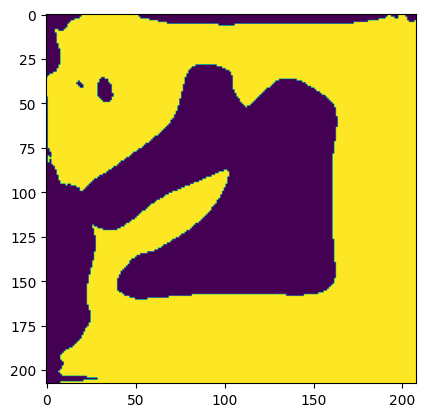

In [6]:
wall_2d = wall[:,:,60]
plt.imshow(wall_2d)
wall_2d

In [67]:
floor_lvl = 0.5/0.04
floor_lvl

12.5

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

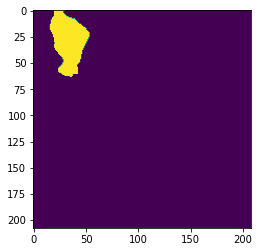

In [83]:
flr_2d = floor[:,:,50]
plt.imshow(flr_2d)
flr_2d

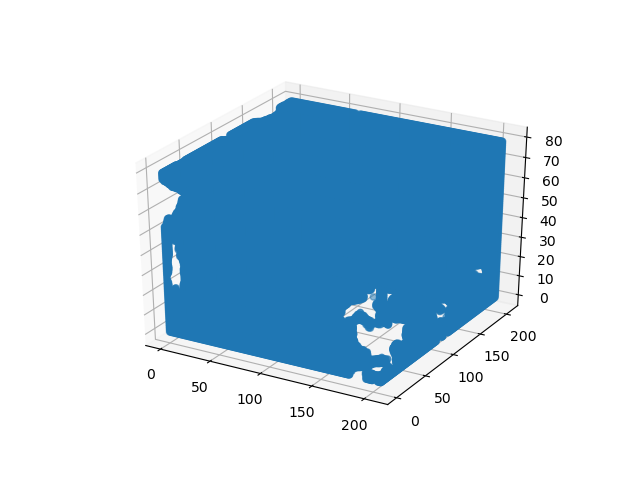

WARNING - 2022-12-02 18:39:36,300 - backend_webagg_core - Unhandled message type dblclick. {'x': 527.5312361511092, 'y': 391.7236234730808, 'button': 0, 'guiEvent': {'isTrusted': True}, 'type': 'dblclick'}


In [93]:
#%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs)
plt.show()
 

In [94]:
wall[0]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [102]:
import OpenGL
import pygame
from pygame.locals import *
from OpenGL.GL import *
from OpenGL.GLU import *
import pywavefront

scene = pywavefront.Wavefront('sample1.obj', collect_faces=True)

In [151]:
import trimesh
from trimesh.exchange.ply import parse_header, ply_binary
PATH = 'sample.ply'
with open(PATH, 'rb') as f:
    elements, is_ascii, image_name = parse_header(f)
    ply_binary(elements, f)
vertex_labels = elements['vertex']['data']['semseg']
vertex= elements['vertex']['data']
#print(vertex[0][0])

coord_wall = []
coord_floor = []
z_f = []
z_w = []
for v in vertex:
    if v[-1] == 1:
        x = v[0]
        y = v[1]
        z = v[2]
        z_w.append(v[2])
        coord_wall.append((x, y, z))
    elif v[-1] == 2:
        #print(v)
        x = v[0]
        y = v[1]
        z = v[2]
        z_f.append(v[2])
        coord_floor.append((x, y, z))
    elif v[-3] == 0 and v[-5]== 0 and v[-4]==0:
        print(v)
# print(elements['vertex'])

In [152]:
face_data = elements['face']['data']
vrtx_data = elements['vertex']['data']

In [231]:
vrtx_data[0]


(0.11866904, 3.9199998, 1.78, 174, 199, 232, 255, 1)

In [217]:
max_z = 0.35
min_z = 0.25
voxel_size = 0.04

# extract wall coordinates lower than max_z
wall = []
for i in range(len(vrtx_data)):
    if vrtx_data[i][7] == 1 and vrtx_data[i][2]<=max_z:
        wall.append([vrtx_data[i][0], vrtx_data[i][1], vrtx_data[i][2]])
wall = np.array(wall)

# extract the floor coordinates
floor = []
for i in range(len(vrtx_data)):
    if vrtx_data[i][7] == 2:
        floor.append([vrtx_data[i][0], vrtx_data[i][1], vrtx_data[i][2]])
floor = np.array(floor)

In [236]:
x_max = None
n = len(floor)

max_x = np.max(floor[:,0])
max_y = np.max(floor[:,1])

min_x = np.min(floor[:,0])
min_y = np.min(floor[:,1])

max_x, max_y, min_x, min_y
np.max((max_x, max_y))

8.28

In [228]:
map_2d = np.zeros([round(max_x/voxel_size)+1, round(max_y/voxel_size)+1])
map_2d.shape

(208, 192)

In [229]:
for i in range(n):
    x = round(floor[i, 0]/voxel_size)
    y = round(floor[i, 1]/voxel_size)
    map_2d[x,y] = 1

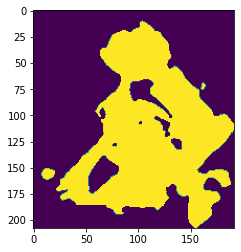

In [230]:
plt.imshow(map_2d)

In [272]:
# %%file map_filter.py
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

class MAP_FILTER():
    def __init__(self, path_2_obj='sample.ply', path_2_npz='sample1.npz'):
        self.obj = self.load_obj(path_2_obj)
        self.npz = self.load_npz(path_2_npz)
        self.voxel_size = self.npz['voxel_size']
        self.vertex_data = self.obj['vertex']['data']
        

        self.ROBOT_HEIGHT_MAX = 0.4
        self.ROBOT_HEIGHT_MIN = 0.25
        self.ROBOT_SIZE_XY = [0.5, 0.6]
        self.ROBOT_STEP_H_MAX = 0.15

    def load_obj(self, path):
        with open(path, 'rb') as f:
            elements, is_ascii, image_name = parse_header(f)
            ply_binary(elements, f)
        return elements

    def load_npz(self, path):
        return np.load(path)

    def extract_floor_coordinates(self):
        floor = []
        for i in range(len(vrtx_data)):
            if vrtx_data[i][7] == 2:
                floor.append([self.vrtx_data[i][0], self.vrtx_data[i][1], self.vrtx_data[i][2]])
        floor = np.array(floor)
        return floor

    def extract_wall_coordinates(self):
        wall = []
        for i in range(len(vrtx_data)):
            if vrtx_data[i][7] == 1:
                wall.append([vrtx_data[i][0], vrtx_data[i][1], vrtx_data[i][2]])
        wall = np.array(wall)
        return wall

    def get_floor_2D_map(self):
        floor = self.extract_floor_coordinates()
        max_x = np.max(floor[:,0])
        max_y = np.max(floor[:,1])
        max_axis_size = round(np.max((max_x, max_y))/self.voxel_size) + 1
        floor_map = np.zeros([max_axis_size, max_axis_size])
        for i in range (len(floor)):
            x = round(floor[i, 0]/voxel_size)
            y = round(floor[i, 1]/voxel_size)
            floor_map[x,y] = 1
        return floor_map
        

        

In [267]:
map = MAP_FILTER()

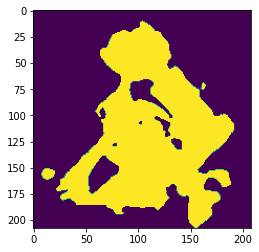

In [268]:
floor = map.get_floor_2D_map()
plt.imshow(floor)

(208, 208)